In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import random
import os
from torch.utils.data import Dataset, DataLoader
from torch import nn
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torch.utils.data.sampler import WeightedRandomSampler
from ignite.metrics import Recall, Precision, Accuracy
from sklearn import metrics
import codecs
from efficientnet_pytorch import model as enet
from sklearn.model_selection import StratifiedKFold

In [22]:
torch.cuda.empty_cache()

### Config

In [23]:
conf_dict = {
    "batch_size": 8,
    "learn_rate": 1e-3,
    "min_learn_rate": 1e-6,
    "weight_decay": 1e-4,
    "epochs": 5,
    "folds": 5,

    "transfer_model_name": "efficientnet-b1",
    "use_backbone": True,

    "input_dir": "../input/seti-breakthrough-listen/",
    "train_dir": "../input/seti-breakthrough-listen/train/",
    "train_csv": "train_labels.csv",
    "test_dir": "../input/seti-breakthrough-listen/test/",
    "test_csv": "sample_submission.csv",
    "efficientnetdir": "../input/efficientnetpytorch/",
    "height": 512,
    "width": 512,

    "model": "schnaufnet_trained",
    "model_to_load": "schnaufnet_trained.pth",

    "origin_height": 273,
    "origin_width": 256,

    "only_use": 1000,
    "behaviours": {
        "all": "all",
        "weighted": "weighted",
    },
    "use_all": True,
    "split_until_ratio": (3 / 4),
    "load_model": False,
}
current_split_behaviour = conf_dict["behaviours"]["weighted"]
new_split_behaviour = conf_dict["behaviours"]["all"]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [24]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

### Custom Dataset

In [25]:
class SETIDataset(Dataset):
	"""Dataset for training data"""
	def __init__(self, df, transform=None, use_cv_preprocessing=False):
		self.df = df
		self.labels = self.df["target"].values
		self.file_names = self.df['file_path'].values
		self.transform = transform
		# self.use_cv_preprocessing = use_cv_preprocessing

	def __len__(self):
		return len(self.df)

	def __getitem__(self, idx):
		file_path = self.file_names[idx]
		image = np.load(file_path)
		image = image.astype(np.float32)

		# if self.use_cv_preprocessing:
		# 	cadence = Cadence(file_path)
		# 	cadence.cv()

		# image = np.vstack(image).T

		# if self.transform:
		# 	image = self.transform(image=image)['image']
		# else:
		# 	image = image[np.newaxis,:,:] # add dimension
		# 	image = torch.from_numpy(image).float()

		label = torch.tensor(self.labels[idx]).float()

		# image = image.repeat(3, 1, 1) # TODO: probably just repeating the single channel isnt the best way => probably converting grayscale to rgb is better

		return image, label



In [26]:
class EfficientNetBackbone(nn.Module):
    def __init__(self, out_dim, backbone=None, load_schnaufnet_model=False):
        super(EfficientNetBackbone, self).__init__()
        print("Initializing Efficientnet Backbone")
        model_name = conf_dict["transfer_model_name"]
        self.enet = enet.EfficientNet.from_name(model_name)
        if not load_schnaufnet_model:
            print("Loading pretrained efficientnet model")
            pretrained_model = {
                model_name: conf_dict["efficientnetdir"] + 'efficientnet-b1-dbc7070a.pth'
            }
            self.enet.load_state_dict(torch.load(pretrained_model[model_name]))
        else:
            print("Loading pretrained schnaufnet model")
            model.load_state_dict(torch.load(conf_dict["model_to_load"]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [27]:
def split(train_index, val_index, behaviour="all"):
    train_df, val_df = df_train.iloc[train_index], df_train.iloc[val_index]
    
    dataset_train = SETIDataset(train_df, transform=get_transforms(data="train"))#, use_cv_preprocessing_preprocessing=True)
    dataset_val = SETIDataset(val_df, transform=get_transforms(data="val"))#, use_cv_preprocessing=True) # extra dataset für validation, da validation data nicht transformiert werden darf

    if behaviour == conf_dict["behaviours"]["weighted"]:
        print("Using 50/50 weighted data...")
        labels = np.array(dataset_train.labels)
        class_counts = np.array(
            [len(np.where(labels == t)[0]) for t in np.unique(labels)])
        num_samples = sum(class_counts)
        class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
        weights = [class_weights[labels[i]] for i in range(int(num_samples))]
        sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
        train_dataloader = DataLoader(
            dataset_train, batch_size=conf_dict["batch_size"], sampler=sampler)
    elif behaviour == conf_dict["behaviours"]["all"]:
        print("Using original full data...")
        train_dataloader = DataLoader(dataset_train, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    val_dataloader = DataLoader(dataset_val, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    print(f"Successfully splitted dataset!\n Trainbatches: {len(train_dataloader)}\n Validationbatches: {len(val_dataloader)}")

    return train_dataloader, val_dataloader

def get_0_1_batches_ratio(dataloader):
    print("dataloader length: ", len(dataloader))
    for i, (data, target) in enumerate(dataloader):
        print (f"batch index {i}, 0/1: {len(np.where(target.numpy() == 0)[0])}/{len(np.where(target.numpy() == 1)[0])}")

def get_0_1_ratio(dataloader, train):
    dataloader_0 = 0
    dataloader_1 = 0
    for i, (data, target) in enumerate(dataloader):
        dataloader_0 += len(np.where(target.numpy() == 0)[0])
        dataloader_1 += len(np.where(target.numpy() == 1)[0])
    dataloaderinformation = "train" if train else "val"
    print(f"{dataloaderinformation} dataloader 0/1 ratio: {dataloader_0}, {dataloader_1}")

In [28]:
def train_loop(model, train_dataloader, optimizer, loss_fn, scheduler):
    print("Starting model training...")
    model.train()
    epoch_loss = 0
    epoch_loss_list = []
    num_batches = len(train_dataloader)

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    for (images, labels) in tqdm(train_dataloader, position=0, leave=True, desc='Training'):
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
        epoch_loss_list.append(loss.item())
        epoch_loss += loss.item() # add loss for whole batch
        loss.backward()
        optimizer.step()
        scheduler.step()
        predicted = torch.sigmoid(pred).round() # if precision gets higher => write own function which does not seperate <0.5 and >=0.5 like round currently does
        accuracy.update((predicted, labels))
        precision.update((predicted, labels))
        recall.update((predicted, labels))

    avg_epoch_loss = epoch_loss / num_batches
    print(f"""Training Error: \n 
        Accuracy: {100*accuracy.compute():>2f}%, \n
        Recall: {100*recall.compute():>2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """) # avg loss is summed losses for all batches divided with num batches
    with codecs.open('logs/schnaufNet2.0 train.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)
    plt.plot(epoch_loss_list, "ro-")
    plt.title("Loss over epoch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

def validation_loop(model, val_dataloader, loss_fn):
    print("Starting model validation...")
    model.eval()

    epoch_loss = 0
    num_batches = len(val_dataloader)
    epoch_labels = []
    epoch_preds = []

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    with torch.no_grad():
        for (images, labels) in tqdm(val_dataloader, position=0, leave=True, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
            epoch_loss += loss.item()
            predicted = torch.sigmoid(pred).round()
            accuracy.update((predicted, labels))
            precision.update((predicted, labels))
            recall.update((predicted, labels))
            
            predicted = torch.sigmoid(pred)
            labels = labels.detach().cpu().numpy().tolist()
            predicted = predicted.detach().cpu().numpy().tolist()
            epoch_labels.extend(labels)
            epoch_preds.extend(predicted)

    avg_epoch_loss = epoch_loss / num_batches
    print(f"""Validation Error: \n
        Accuracy: {100*accuracy.compute():2f}%, \n
        Recall: {100*recall.compute():2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """)
    with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)
    return epoch_labels, epoch_preds

In [29]:
def get_transforms(data):
    pass
    # if data == 'train':
    #     return A.Compose([
    #         A.Resize(conf_dict["height"], conf_dict["width"]),
    #         A.VerticalFlip(p=0.5),
    #         A.HorizontalFlip(p=0.5),
    #         ToTensorV2(),
    #     ])
    # elif data == 'val' or data == 'test':
    #     return A.Compose([
    #         A.Resize(conf_dict["height"], conf_dict["width"]),
    #         ToTensorV2(),
    #     ])

def get_file_path(target, directory):
    return directory + "{}/{}.npy".format(target[0], target)

Initializing Efficientnet Backbone
Loading pretrained efficientnet model
Fold 1/5 | Epoch 1/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [36:16<00:00,  2.76it/s] 

Training Error: 
 
        Accuracy: 60.995833%, 

        Recall: 50.164303%, 

        Precision: 64.145524%, 

        Avg loss: 0.635751 

    


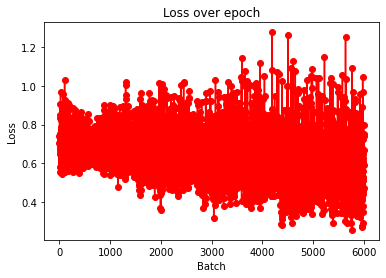

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:28<00:00,  2.95it/s]


Validation Error: 

        Accuracy: 90.108333%, 

        Recall: 36.750000%, 

        Precision: 50.747986%, 

        Avg loss: 0.526299 

    
Val ROC AUC Score: 0.7135380401234568
Fold 1/5 | Epoch 2/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:37<00:00,  3.07it/s]

Training Error: 
 
        Accuracy: 69.227083%, 

        Recall: 56.557752%, 

        Precision: 75.817431%, 

        Avg loss: 0.555018 

    


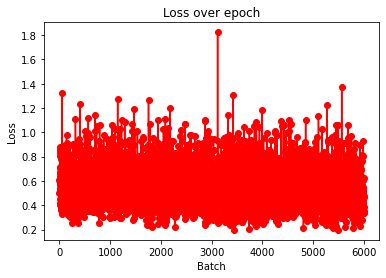

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:46<00:00,  3.69it/s]


Validation Error: 

        Accuracy: 84.458333%, 

        Recall: 48.166667%, 

        Precision: 31.740802%, 

        Avg loss: 0.450846 

    
Val ROC AUC Score: 0.7496046296296296
Fold 1/5 | Epoch 3/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [31:56<00:00,  3.13it/s]

Training Error: 
 
        Accuracy: 71.822917%, 

        Recall: 59.949308%, 

        Precision: 78.781260%, 

        Avg loss: 0.527651 

    


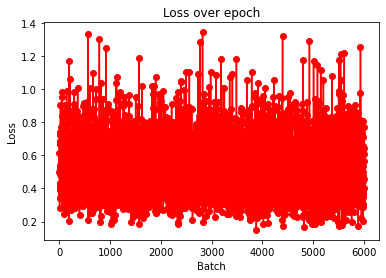

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:06<00:00,  3.52it/s]


Validation Error: 

        Accuracy: 91.083333%, 

        Recall: 40.750000%, 

        Precision: 57.665094%, 

        Avg loss: 0.362130 

    
Val ROC AUC Score: 0.7535178240740741
Fold 1/5 | Epoch 4/5
-------------------------------
Using all behaviour
Using original full data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [42:45<00:00,  2.34it/s]

Training Error: 
 
        Accuracy: 92.681250%, 

        Recall: 32.125000%, 

        Precision: 85.809683%, 

        Avg loss: 0.242382 

    


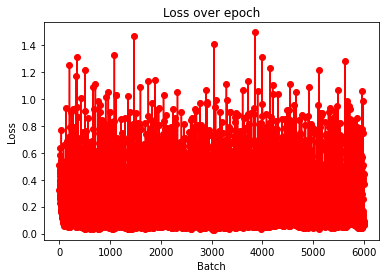

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:59<00:00,  3.58it/s]


Validation Error: 

        Accuracy: 92.616667%, 

        Recall: 28.833333%, 

        Precision: 91.534392%, 

        Avg loss: 0.249572 

    
Val ROC AUC Score: 0.7477148148148147
Fold 1/5 | Epoch 5/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:31<00:00,  3.07it/s]

Training Error: 
 
        Accuracy: 73.937500%, 

        Recall: 62.692179%, 

        Precision: 80.738190%, 

        Avg loss: 0.503129 

    


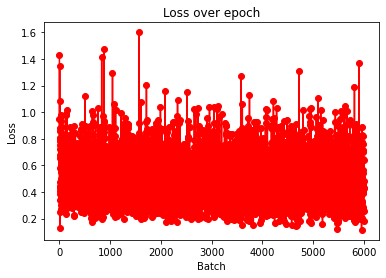

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:15<00:00,  3.45it/s]


Validation Error: 

        Accuracy: 89.283333%, 

        Recall: 41.333333%, 

        Precision: 46.011132%, 

        Avg loss: 0.370186 

    
Val ROC AUC Score: 0.7460581404320987
Initializing Efficientnet Backbone
Loading pretrained efficientnet model
Fold 2/5 | Epoch 1/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [29:56<00:00,  3.34it/s]

Training Error: 
 
        Accuracy: 62.177083%, 

        Recall: 54.188970%, 

        Precision: 64.731833%, 

        Avg loss: 0.635876 

    


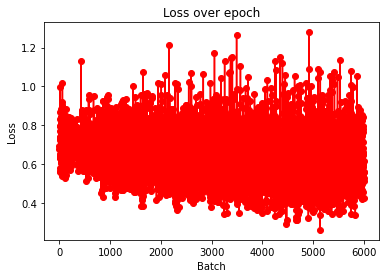

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:04<00:00,  3.54it/s]


Validation Error: 

        Accuracy: 89.725000%, 

        Recall: 37.166667%, 

        Precision: 48.216216%, 

        Avg loss: 0.446999 

    
Val ROC AUC Score: 0.7268633873456791
Fold 2/5 | Epoch 2/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:10<00:00,  3.11it/s]

Training Error: 
 
        Accuracy: 68.668750%, 

        Recall: 57.996251%, 

        Precision: 73.747219%, 

        Avg loss: 0.567159 

    


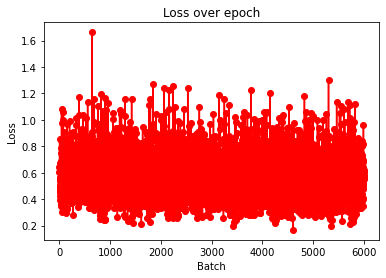

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:47<00:00,  3.68it/s]


Validation Error: 

        Accuracy: 90.625000%, 

        Recall: 37.833333%, 

        Precision: 54.501801%, 

        Avg loss: 0.416994 

    
Val ROC AUC Score: 0.7449459104938272
Fold 2/5 | Epoch 3/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:04<00:00,  3.12it/s]

Training Error: 
 
        Accuracy: 72.056250%, 

        Recall: 61.960063%, 

        Precision: 77.496212%, 

        Avg loss: 0.531343 

    


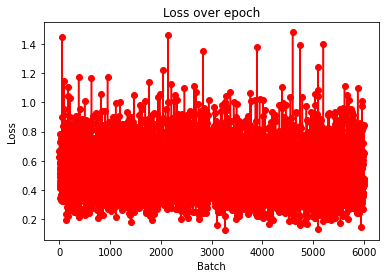

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:58<00:00,  3.58it/s]


Validation Error: 

        Accuracy: 79.583333%, 

        Recall: 52.250000%, 

        Precision: 25.039936%, 

        Avg loss: 0.486963 

    
Val ROC AUC Score: 0.7428112654320989
Fold 2/5 | Epoch 4/5
-------------------------------
Using all behaviour
Using original full data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [43:06<00:00,  2.32it/s] 

Training Error: 
 
        Accuracy: 92.322917%, 

        Recall: 29.375000%, 

        Precision: 82.697947%, 

        Avg loss: 0.248439 

    


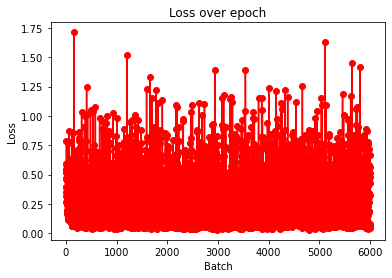

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:54<00:00,  3.62it/s]


Validation Error: 

        Accuracy: 92.616667%, 

        Recall: 28.500000%, 

        Precision: 92.432432%, 

        Avg loss: 0.254575 

    
Val ROC AUC Score: 0.7427956018518518
Fold 2/5 | Epoch 5/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:47<00:00,  3.05it/s]

Training Error: 
 
        Accuracy: 74.843750%, 

        Recall: 66.517577%, 

        Precision: 79.652618%, 

        Avg loss: 0.498189 

    


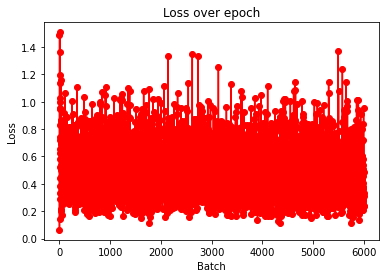

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:54<00:00,  3.62it/s]


Validation Error: 

        Accuracy: 89.391667%, 

        Recall: 41.500000%, 

        Precision: 46.585594%, 

        Avg loss: 0.340129 

    
Val ROC AUC Score: 0.7375998456790124
Initializing Efficientnet Backbone
Loading pretrained efficientnet model
Fold 3/5 | Epoch 1/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [30:03<00:00,  3.33it/s]

Training Error: 
 
        Accuracy: 59.529167%, 

        Recall: 51.138673%, 

        Precision: 61.717146%, 

        Avg loss: 0.650547 

    


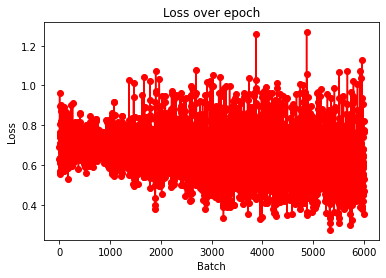

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:00<00:00,  3.57it/s]


Validation Error: 

        Accuracy: 91.333333%, 

        Recall: 29.333333%, 

        Precision: 64.705882%, 

        Avg loss: 0.374514 

    
Val ROC AUC Score: 0.7221640046296296
Fold 3/5 | Epoch 2/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:18<00:00,  3.10it/s]

Training Error: 
 
        Accuracy: 67.881250%, 

        Recall: 55.255444%, 

        Precision: 73.604061%, 

        Avg loss: 0.575487 

    


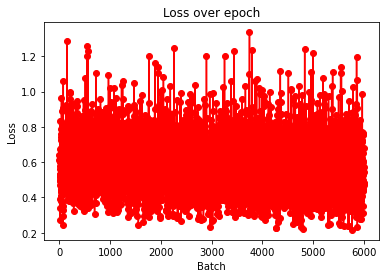

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:47<00:00,  3.68it/s]


Validation Error: 

        Accuracy: 90.525000%, 

        Recall: 38.833333%, 

        Precision: 53.624856%, 

        Avg loss: 0.429237 

    
Val ROC AUC Score: 0.736257986111111
Fold 3/5 | Epoch 3/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [47:19<00:00,  2.11it/s]   


Training Error: 
 
        Accuracy: 70.760417%, 

        Recall: 58.829386%, 

        Precision: 77.531161%, 

        Avg loss: 0.540084 

    


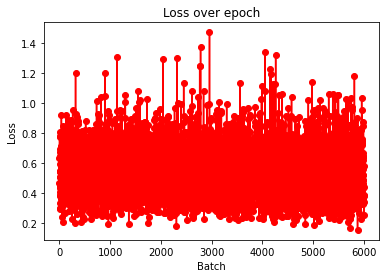

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:21<00:00,  3.40it/s]


Validation Error: 

        Accuracy: 83.050000%, 

        Recall: 51.000000%, 

        Precision: 29.737609%, 

        Avg loss: 0.455450 

    
Val ROC AUC Score: 0.7584134259259259
Fold 3/5 | Epoch 4/5
-------------------------------
Using all behaviour
Using original full data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [48:00<00:00,  2.08it/s]  


Training Error: 
 
        Accuracy: 92.312500%, 

        Recall: 29.250000%, 

        Precision: 82.685512%, 

        Avg loss: 0.252234 

    


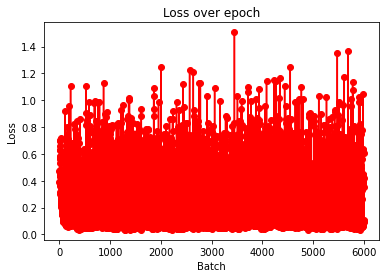

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:07<00:00,  3.08it/s]


Validation Error: 

        Accuracy: 92.450000%, 

        Recall: 27.250000%, 

        Precision: 90.833333%, 

        Avg loss: 0.254986 

    
Val ROC AUC Score: 0.7399045524691357
Fold 3/5 | Epoch 5/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [47:38<00:00,  2.10it/s]  


Training Error: 
 
        Accuracy: 72.825000%, 

        Recall: 61.907531%, 

        Precision: 79.368376%, 

        Avg loss: 0.519834 

    


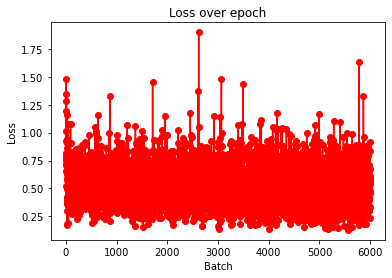

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [15:33<00:00,  1.61it/s] 


Validation Error: 

        Accuracy: 75.425000%, 

        Recall: 58.083333%, 

        Precision: 22.176265%, 

        Avg loss: 0.554472 

    
Val ROC AUC Score: 0.7453128086419754
Initializing Efficientnet Backbone
Loading pretrained efficientnet model
Fold 4/5 | Epoch 1/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [53:06<00:00,  1.88it/s]  


Training Error: 
 
        Accuracy: 61.058333%, 

        Recall: 51.376643%, 

        Precision: 63.826599%, 

        Avg loss: 0.637942 

    


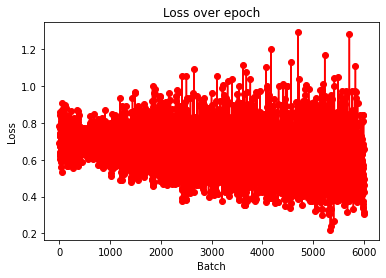

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:44<00:00,  2.86it/s]


Validation Error: 

        Accuracy: 90.725000%, 

        Recall: 33.416667%, 

        Precision: 56.083916%, 

        Avg loss: 0.363719 

    
Val ROC AUC Score: 0.7275000385802469
Fold 4/5 | Epoch 2/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [42:31<00:00,  2.35it/s]  

Training Error: 
 
        Accuracy: 68.114583%, 

        Recall: 54.325578%, 

        Precision: 74.844613%, 

        Avg loss: 0.569153 

    


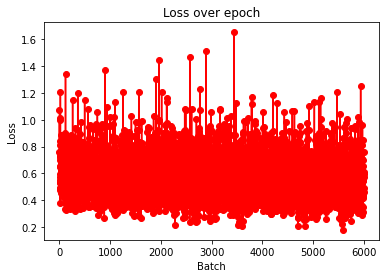

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:05<00:00,  3.09it/s]


Validation Error: 

        Accuracy: 86.950000%, 

        Recall: 48.083333%, 

        Precision: 37.960526%, 

        Avg loss: 0.503627 

    
Val ROC AUC Score: 0.7570052083333334
Fold 4/5 | Epoch 3/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [43:30<00:00,  2.30it/s]  


Training Error: 
 
        Accuracy: 71.037500%, 

        Recall: 58.001750%, 

        Precision: 78.459111%, 

        Avg loss: 0.535526 

    


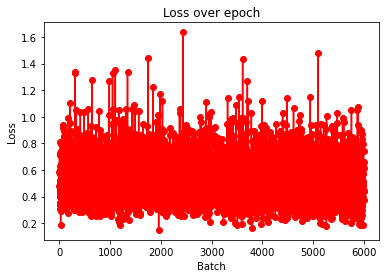

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:39<00:00,  2.89it/s]


Validation Error: 

        Accuracy: 87.108333%, 

        Recall: 46.500000%, 

        Precision: 38.140807%, 

        Avg loss: 0.407991 

    
Val ROC AUC Score: 0.7560334876543211
Fold 4/5 | Epoch 4/5
-------------------------------
Using all behaviour
Using original full data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [45:52<00:00,  2.18it/s] 

Training Error: 
 
        Accuracy: 92.427083%, 

        Recall: 30.229167%, 

        Precision: 83.534830%, 

        Avg loss: 0.248644 

    


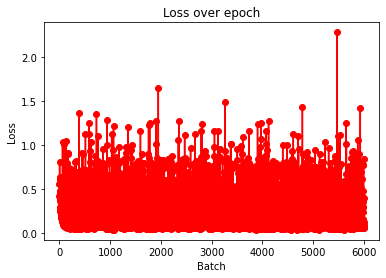

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:59<00:00,  2.78it/s]


Validation Error: 

        Accuracy: 92.891667%, 

        Recall: 35.000000%, 

        Precision: 85.192698%, 

        Avg loss: 0.247722 

    
Val ROC AUC Score: 0.734655825617284
Fold 4/5 | Epoch 5/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [40:33<00:00,  2.47it/s] 

Training Error: 
 
        Accuracy: 73.054167%, 

        Recall: 62.290665%, 

        Precision: 79.659669%, 

        Avg loss: 0.515627 

    


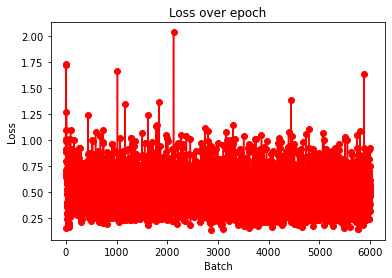

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:32<00:00,  3.32it/s]


Validation Error: 

        Accuracy: 89.325000%, 

        Recall: 43.583333%, 

        Precision: 46.406389%, 

        Avg loss: 0.385856 

    
Val ROC AUC Score: 0.7583237268518519
Initializing Efficientnet Backbone
Loading pretrained efficientnet model
Fold 5/5 | Epoch 1/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [45:07<00:00,  2.22it/s]  

Training Error: 
 
        Accuracy: 60.491667%, 

        Recall: 51.578512%, 

        Precision: 63.270479%, 

        Avg loss: 0.641520 

    


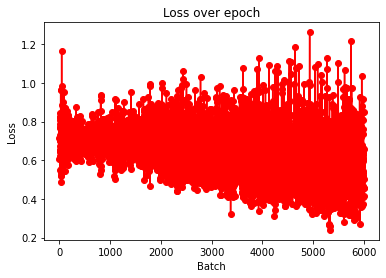

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [09:27<00:00,  2.64it/s]


Validation Error: 

        Accuracy: 88.950000%, 

        Recall: 36.416667%, 

        Precision: 43.700000%, 

        Avg loss: 0.472463 

    
Val ROC AUC Score: 0.7001251157407408
Fold 5/5 | Epoch 2/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training:  38%|███▊      | 2289/6000 [21:12<34:23,  1.80it/s]  


KeyboardInterrupt: 

In [30]:
df_train = pd.read_csv(conf_dict["input_dir"] + conf_dict["train_csv"])
if not conf_dict["use_all"]:
    df_train = df_train[:conf_dict["only_use"]]
df_train["file_path"] = df_train["id"].apply(get_file_path, directory=conf_dict["train_dir"])

loss_fn = nn.BCEWithLogitsLoss() # nn.BCELoss() => needs sigmoid as activation function
num_epochs = conf_dict["epochs"]
num_folds = conf_dict["folds"]
skf = StratifiedKFold(n_splits=num_folds)

with codecs.open('logs/schnaufNet2.0 train.log', 'a') as up:
    up.write("------------------ new training ------------------")
with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
    up.write("------------------ new validation ------------------")

for fold, (train_index, val_index) in enumerate(skf.split(df_train, df_train["target"])):
    model = EfficientNetBackbone(out_dim=1, load_schnaufnet_model=conf_dict["load_model"])
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=conf_dict["learn_rate"], weight_decay=conf_dict["weight_decay"]) # torch.optim.SGD(model.parameters(), lr=conf_dict["learn_rate"]) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=conf_dict["epochs"], eta_min=conf_dict["min_learn_rate"], last_epoch=-1
    )
    best_roc_auc = 0
    best_roc_auc_fold = 1
    best_roc_auc_fold_epoch = 1
    for epoch in range(num_epochs):
        print(f"Fold {fold + 1}/{num_folds} | Epoch {epoch + 1}/{num_epochs}\n-------------------------------")
        if epoch == math.floor(num_epochs * conf_dict["split_until_ratio"]):
            print(f"Using {new_split_behaviour} behaviour")
            train_dataloader, val_dataloader = split(train_index, val_index, behaviour=new_split_behaviour)
        else:
            print(f"Using {current_split_behaviour} behaviour")
            train_dataloader, val_dataloader = split(train_index, val_index, behaviour=current_split_behaviour)
        train_loop(model, train_dataloader, optimizer, loss_fn, scheduler)
        val_labels, val_predictions = validation_loop(model, val_dataloader, loss_fn)
        roc_auc = metrics.roc_auc_score(val_labels, val_predictions)
        print(f"Val ROC AUC Score: {roc_auc}")
        with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
            up.write(f"""
                Epoch={epoch}, Valid ROC AUC={roc_auc}\n
            """)
        if roc_auc > best_roc_auc:
            torch.save(model.state_dict(), "best_roc_auc_" + conf_dict["model"] + "-" + str(fold) + "-" + str(epoch) + ".pth")
            best_roc_auc = roc_auc
            best_roc_auc_fold = fold
            best_roc_auc_epoch = epoch
    # torch.save(model.state_dict(), "version_" + conf_dict["model"] + "-" + str(fold) + ".pth")
print(f"Training done! Best model in fold {best_roc_auc_fold}, epoch {best_roc_auc_epoch} with roc_auc of {best_roc_auc}")